Author: Bob Hampton

This is the code for the LSTM model used in "Predicting Bitcoin Prices: A Comparative Study of LSTM, Random Forest, and SVM Approaches".

First we must set up our environment, API keys, logging, and random seed. 

In [16]:
import os
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import random
import numpy as np
import tensorflow as tf
import logging

def init_env():
    load_dotenv()
    api_key = os.getenv("ALPACA_API_KEY")
    secret_key = os.getenv("ALPACA_SECRET_KEY")
    base_url = "https://paper-api.alpaca.markets"

    if not api_key or not secret_key:
        raise EnvironmentError("Missing ALPACA_API_KEY or ALPACA_SECRET_KEY in environment variables.")

    api = tradeapi.REST(key_id=api_key, secret_key=secret_key, base_url=base_url, api_version='v2')
    return api_key, secret_key, base_url, api

def set_random_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s - %(message)s',
    datefmt='%H:%M:%S'
)
log = logging.getLogger(__name__)

set_random_seed(42)
init_env()

print("Initial setup complete.")

Initial setup complete.


To make sure everything is working properly, let's download our data and display the first 5 lines of our dataset using the Alpaca API

In [17]:
import pandas as pd
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
import ta
from alpaca.data.timeframe import TimeFrame

# Load API creds once
api_key, secret_key, _, _ = init_env()

def crypto_bars(symbol, start_date, end_date, limit, timeframe):
    try:
        crypto_data_client = CryptoHistoricalDataClient(api_key, secret_key)
        request = CryptoBarsRequest(
            symbol_or_symbols=symbol,
            start=start_date,
            end=end_date,
            limit=limit,
            timeframe=timeframe
        )
        bar_data = crypto_data_client.get_crypto_bars(request_params=request)
        return bar_data.df
    except Exception as e:
        print(f"[crypto_bars] Error fetching bars for {symbol}: {e}")
        return pd.DataFrame()

df = crypto_bars(
        symbol='BTC/USD',
        start_date="2021-01-01",
        end_date="2025-04-14",
        limit=None,
        timeframe=TimeFrame.Hour
    )

df = df.reset_index()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['close'] = df[[col for col in df.columns if 'close' in col.lower()]].squeeze()


print(df.head(5))

    symbol                 timestamp      open      high       low     close  \
0  BTC/USD 2021-01-01 06:00:00+00:00  29255.71  29338.25  29153.55  29234.15   
1  BTC/USD 2021-01-01 07:00:00+00:00  29235.61  29236.95  28905.00  29162.50   
2  BTC/USD 2021-01-01 08:00:00+00:00  29162.50  29248.52  28948.86  29076.77   
3  BTC/USD 2021-01-01 09:00:00+00:00  29075.31  29372.32  29058.05  29284.92   
4  BTC/USD 2021-01-01 10:00:00+00:00  29291.54  29400.00  29232.16  29286.63   

      volume  trade_count          vwap  
0  42.244289       1243.0  29237.240312  
1  34.506038       1070.0  29078.423185  
2  27.596804       1110.0  29091.465155  
3  20.694200        880.0  29248.730924  
4  16.617646        742.0  29338.609132  


Now that we are sure that everything is working correctly and we have our dataset, we must inspect the data and check for any missing values or any outliers

In [18]:
def describe_data(df):
    print("Statistical summary of raw BTC data:")
    print(df.describe())

def check_missing_and_outliers(df):
    print("\nMissing values:")
    print(df.isnull().sum())

    # Outlier check for 'close' using IQR
    Q1 = df['close'].quantile(0.25)
    Q3 = df['close'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['close'] < Q1 - 1.5 * IQR) | (df['close'] > Q3 + 1.5 * IQR)]
    print(f"\nDetected {len(outliers)} potential outliers in closing prices.")

describe_data(df)
check_missing_and_outliers(df)


Statistical summary of raw BTC data:
                open           high            low          close  \
count   37519.000000   37519.000000   37519.000000   37519.000000   
mean    45858.513519   46058.776782   45644.343267   45858.338172   
std     22018.248696   22098.340253   21940.018422   22018.667351   
min     15627.650000   15750.440000    8200.000000   15631.840000   
25%     27920.154750   27998.020750   27828.529825   27920.262282   
50%     41854.578500   42027.490000   41678.980000   41851.330000   
75%     60664.529500   60874.506250   60388.882750   60662.395000   
max    108249.820000  109379.685000  107781.503000  108287.880000   

             volume    trade_count           vwap  
count  37519.000000   37519.000000   37519.000000  
mean      88.515814    2002.166369   44812.795455  
std      189.369510    3369.853331   22745.091629  
min        0.000000       0.000000       0.000000  
25%        0.024564       5.000000   27229.149035  
50%       20.277664    1053.0

We will make a directory to store all of our trained models in case we need to use them again.

In [19]:
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

Now we need to add the technical indicators that we will be using:

In [20]:
def add_technical_indicators(df):
    # First we will copy and sort the DataFrame to ensure chronological order
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')

    # RSI
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()

    # Bollinger Band Width
    bb = ta.volatility.BollingerBands(df['close'], window=20, window_dev=2)
    df['bb_width'] = bb.bollinger_wband()

    # Volume Scaled
    if 'volume' in df.columns:
        df['volume_scaled'] = (df['volume'] - df['volume'].mean()) / df['volume'].std()
    else:
        df['volume_scaled'] = 0

    # MACD
    macd = ta.trend.MACD(df['close'], window_slow=26, window_fast=12, window_sign=9)
    df['macd_line'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_hist'] = macd.macd_diff()

    # On-Balance Volume
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(
        close=df['close'],
        volume=df.get('volume', pd.Series(0))
    ).on_balance_volume()

    # Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=14,
        smooth_window=3
    )
    df['stoch_k'] = stoch.stoch()
    df['stoch_d'] = stoch.stoch_signal()

    # ADX
    df['adx'] = ta.trend.ADXIndicator(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=14
    ).adx()

    # CCI
    df['cci'] = ta.trend.CCIIndicator(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=20
    ).cci()

    return df

df = add_technical_indicators(df)
print("Technical indicators added.")
print(df.head(5))

Technical indicators added.
    symbol                 timestamp      open      high       low     close  \
0  BTC/USD 2021-01-01 06:00:00+00:00  29255.71  29338.25  29153.55  29234.15   
1  BTC/USD 2021-01-01 07:00:00+00:00  29235.61  29236.95  28905.00  29162.50   
2  BTC/USD 2021-01-01 08:00:00+00:00  29162.50  29248.52  28948.86  29076.77   
3  BTC/USD 2021-01-01 09:00:00+00:00  29075.31  29372.32  29058.05  29284.92   
4  BTC/USD 2021-01-01 10:00:00+00:00  29291.54  29400.00  29232.16  29286.63   

      volume  trade_count          vwap  rsi  bb_width  volume_scaled  \
0  42.244289       1243.0  29237.240312  NaN       NaN      -0.244345   
1  34.506038       1070.0  29078.423185  NaN       NaN      -0.285208   
2  27.596804       1110.0  29091.465155  NaN       NaN      -0.321694   
3  20.694200        880.0  29248.730924  NaN       NaN      -0.358144   
4  16.617646        742.0  29338.609132  NaN       NaN      -0.379671   

   macd_line  macd_signal  macd_hist        obv  sto

Discussion on why these indicators were chosen:

Momentum Indicators
RSI (Relative Strength Index): Measures the speed and change of price movements over a 14-period window. Ranging from 0-100, typically when RSI>70 it indicates overbought conditions and when RSI<30 it indicates oversold conditions. 
Stochastic Oscillator: A momentum indicator that compares the closing price to the price range over a 14-period window.
These will help highlight potential turning points in the market, which is crucial for predicting future prices.

Trend Indicators
MACD (Moving Average Convergence Divergence): Is a trend-following momentum indicator and can show the relationship between fast and slow moving averages.
ADX (Average Directional Index): Measures the strength of a trend over a 14-period window. Values range from 0-100 and higher values indicate a stronger trend.
CCI (Commodity Channel Index): Measures the deviation of the price from its average over a 20-period window where positive/negative values indicate overbought/oversold conditions.
These will help the model understand if the market is trending or consolidating.

Volatility Indicator
Bollinger Bands: Volatility indicater that creates bands around a moving average. During high/low volatility the bands expand expand/contract.
This will help the model adjust its prediction based on the level of market uncertainty

Volume-Based Indicators
OBV (On-Balance Volume): Volume-based indicator that measures buying and selling pressure.
Scale Volume: Is used to standardize the volume column by subtracting the mean and dividing by the standard deviation.
These will help provide context for price movements and help the model distinguish between strong/weak trends.











In [21]:
df['date'] = df['timestamp'].dt.date

# Feature engineering
df['log_return'] = np.log(df['close'].shift(-1) / df['close'])
df['target'] = df['log_return'] * 100

df['ma_20'] = df['close'].rolling(20).mean()
df['ma_ratio'] = df['close'] / df['ma_20']
df['volatility_20'] = df['close'].rolling(20).std()
df['daily_range'] = (df['high'] - df['low']) / df['close']
df['body_size'] = abs(df['close'] - df['open']) / df['close']

feature_cols = [
    'close', 'rsi', 'bb_width', 'volume_scaled',
    'macd_line', 'macd_signal', 'macd_hist',
    'obv', 'stoch_k', 'stoch_d', 'adx', 'cci',
    'ma_ratio', 'volatility_20', 'daily_range', 'body_size'
]

# Drop rows with NaN values in feature columns or target
df = df.dropna(subset=feature_cols + ['target'])
all_dates = sorted(df['date'].unique())

print(df.head(5))

     symbol                 timestamp      open      high       low     close  \
33  BTC/USD 2021-01-02 15:00:00+00:00  31339.03  31888.00  31302.48  31763.00   
34  BTC/USD 2021-01-02 16:00:00+00:00  31763.00  33100.47  31763.00  32551.22   
35  BTC/USD 2021-01-02 17:00:00+00:00  32525.77  33000.00  32461.72  32940.01   
36  BTC/USD 2021-01-02 18:00:00+00:00  32940.01  33338.68  32515.63  33007.47   
37  BTC/USD 2021-01-02 19:00:00+00:00  33027.57  33289.92  32772.47  33087.84   

        volume  trade_count          vwap        rsi  ...        adx  \
33   80.308968       2299.0  31553.015623  81.229126  ...  25.287929   
34  244.488728       5082.0  32481.217808  85.297424  ...  28.872718   
35  101.378913       3148.0  32739.524145  86.815346  ...  32.201451   
36  111.226347       2906.0  32864.086911  87.064887  ...  35.460728   
37   83.076149       3862.0  33070.053726  87.371546  ...  38.487198   

           cci        date  log_return    target       ma_20  ma_ratio  \
33  22

Now we will split the dataset into 80% for training and 20% for testing.

In [22]:
split_idx = int(len(all_dates) * 0.8)
train_dates = all_dates[:split_idx]
test_dates = all_dates[split_idx:]

train_df = df[df['date'].isin(train_dates)]

In order to improve our model and reduce training time, we will extract the top 30% of the most volitile windows to train.

In [23]:
def extract_high_volatility_window(df, window_size=20, top_pct=0.3):
    df = df.copy()
    df['rolling_vol'] = df['close'].rolling(window=window_size).std()
    df = df.dropna()

    threshold = df['rolling_vol'].quantile(1 - top_pct)
    high_vol_df = df[df['rolling_vol'] >= threshold]

    return high_vol_df

train_df = extract_high_volatility_window(train_df)

Calculate key statistics about daily price changes and update the name of the model to include the date range that the model was trained on.

In [24]:
train_eod = train_df.groupby('date')['close'].last()
daily_deltas = train_eod.diff().dropna()
delta_mean = daily_deltas.abs().mean()
delta_std = daily_deltas.abs().std()
print(f"Estimated EOD Delta Mean: {delta_mean:.2f} | Std Dev: {delta_std:.2f}")

model_name = f"hybrid_{train_dates[0]}_{train_dates[-1]}.keras"
model_path = os.path.join(model_dir, model_name)

Estimated EOD Delta Mean: 1446.20 | Std Dev: 1277.13


Prepare the data for training the LSTM model by creating sequences of input data and scaling the features and target.

In [25]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from sklearn.preprocessing import StandardScaler

def prepare_eod_training_data_hybrid(df, lookback=120):
    df = df.copy()
    df['log_return'] = np.log(df['close'].shift(-1) / df['close'])
    df['target'] = df['log_return'] * 100  # <- Scale return

    # Feature engineering
    df['ma_20'] = df['close'].rolling(20).mean()
    df['ma_ratio'] = df['close'] / df['ma_20']
    df['volatility_20'] = df['close'].rolling(20).std()
    df['daily_range'] = (df['high'] - df['low']) / df['close']
    df['body_size'] = abs(df['close'] - df['open']) / df['close']

    feature_cols = [
        'close', 'rsi', 'bb_width', 'volume_scaled',
        'macd_line', 'macd_signal', 'macd_hist',
        'obv', 'stoch_k', 'stoch_d', 'adx', 'cci',
        'ma_ratio', 'volatility_20', 'daily_range', 'body_size'
    ]

    df = df.dropna(subset=feature_cols + ['target'])

    X, y = [], []
    for i in range(lookback, len(df)):
        X.append(df.iloc[i - lookback:i][feature_cols].values)
        y.append(df.iloc[i]['target'])

    X = np.array(X)
    y = np.array(y)

    x_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_scaled = np.array([x_scaler.fit_transform(x) for x in X])
    y_scaled = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

    return X_scaled, y_scaled, x_scaler, y_scaler

lookback = 120
X_train, y_train, x_scaler, y_scaler = prepare_eod_training_data_hybrid(train_df, lookback)
input_shape = (X_train.shape[1], X_train.shape[2])

Load model from file if it already exists or train a new model and save it.

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def load_model_from_file(path='btc_lstm_model.keras'):
    return load_model(path)

def build_hybrid_LSTM_model(input_shape, units=64, dropout=0.2):
    model = Sequential()
    model.add(Input(shape=input_shape))  # (lookback, features)
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units))
    model.add(Dropout(dropout))
    model.add(Dense(1))  # Predict EOD price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

if os.path.exists(model_path):
    print(f"[MODEL] Loading cached model from {model_path}")
    model = load_model_from_file(model_path)
else:
    print(f"[MODEL] Training new model -> {model_path}")
    model = build_hybrid_LSTM_model(input_shape)
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=0)

    y_pred_train = model.predict(X_train, verbose=0)
    y_true_inv = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_pred_inv = y_scaler.inverse_transform(y_pred_train).flatten()

    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
    print(f"[TRAIN METRICS] MAE: {mae:.4f} | RMSE: {rmse:.4f}")

    model.save(model_path)
    print(f"[MODEL] Saved to {model_path}")

y_pred_train = model.predict(X_train, verbose=0)
y_true_inv = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_pred_inv = y_scaler.inverse_transform(y_pred_train).flatten()

[MODEL] Loading cached model from models/hybrid_2021-01-02_2024-06-04.keras


Initialize variables and set thresholds.

In [27]:
initial_cash=10000 
qty=0.01
cooldown_days=2
lookahead_days=3
cash, btc_available, btc_locked_hodl = initial_cash, 0.0, 0.0
active_trades = []
trade_log, portfolio_values = [], []
last_buy_date = None
std_history = []
rolling_window = 5
dynamic_std_limit_min = 2000
unlock_log = []
initial_portfolio_value = initial_cash
profit_lock_threshold = initial_cash * 1.10
low_cash_threshold = initial_cash * 0.10
min_cash_restore_target = initial_cash * 0.25

Before we run our simulation, we have to define our function to predict the EOD price using our model and estimate the uncertainty of those predictions.

In [28]:
# Fast = batch prediction
# Slow = sequential prediction
def predict_eod_with_uncertainty(model, scaler, input_sequence, n_simulations=30, mode='fast'):
    if mode == 'fast':
        input_seq_reshaped = input_sequence.reshape(1, *input_sequence.shape)
        input_seq_batch = np.repeat(input_seq_reshaped, n_simulations, axis=0)  # shape: (30, lookback, features)

        predictions_scaled = model(input_seq_batch, training=True).numpy()
        predictions = scaler.inverse_transform(predictions_scaled)

        mean_pred = predictions.mean()
        std_pred = predictions.std()

        return mean_pred, std_pred

    elif mode == 'slow':
        preds = []
        input_seq_reshaped = input_sequence.reshape(1, *input_sequence.shape)
        for _ in range(n_simulations):
            predicted_scaled = model(input_seq_reshaped, training=True)
            predicted = scaler.inverse_transform(predicted_scaled)[0][0]
            preds.append(predicted)
        return np.mean(preds), np.std(preds)

Run simulation on our testing set and log the results.

Trading logic:
The model predicts the next-day log return and derives a predicted EOD price using current market data and LSTM outputs.
A cumulative price delta is estimated across the next 3 days to assess short-term trend direction.
BUY is triggered if this delta exceeds a dynamic buy threshold and the prediction’s standard deviation is below a rolling volatility-based limit.
The quantity bought is scaled using a confidence score based on prediction certainty and a position multiplier that increases with portfolio growth.
SELL occurs when the predicted cumulative delta falls below a strong negative threshold and the trader holds enough BTC.
Trades are only made if not in a cooldown period, and capital or BTC reserves are checked to avoid illiquid positions.

HODL BTC logic:
Locked BTC becomes eligible for partial release only when your portfolio grows by at least +10% over the previous unlock point.
Upon hitting this profit lock threshold, 50% of locked BTC is moved to the available pool for trading.
A growth multiplier is calculated to adjust future position sizes, boosting buy power during profitable streaks.
The unlock threshold resets to 110% of the current portfolio value after each unlock, ensuring progressive profit-lock steps.
If the cash balance drops below 10% and you have no tradable BTC, the strategy performs an emergency unlock of 25% of locked BTC to restore liquidity.
These mechanisms enforce a balance between aggressive scaling during wins and reserve protection during drawdowns.

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statistics import mean

for i in range(1, len(test_dates)):
    prev_day = test_dates[i - 1]
    curr_day = test_dates[i]

    # Extract data for the previous and current day
    prev_data = df[df['date'] == prev_day]
    curr_data = df[df['date'] == curr_day]
    hist = df[df['timestamp'] < curr_data['timestamp'].iloc[0]].tail(lookback)

    # Skip iteration if historical data or daily data is insufficient
    if len(hist) < lookback or len(prev_data) < 24 or len(curr_data) < 24:
        continue

    # Get actual EOD prices for the previous and current day
    actual_prev_eod = prev_data['close'].iloc[-1]
    actual_today_eod = curr_data['close'].iloc[-1]

    # Prepare input sequence for prediction
    input_seq = hist[feature_cols].values
    input_scaled = x_scaler.transform(input_seq).reshape(1, lookback, len(feature_cols))
    mean_pred, std_pred = predict_eod_with_uncertainty(model, y_scaler, input_seq, n_simulations=30, mode='fast')

    # Calculate predicted price based on log return
    predicted_log_return = mean_pred / 100
    predicted_price = actual_prev_eod * np.exp(predicted_log_return)

    # Calculate total portfolio value
    total_btc = btc_available + btc_locked_hodl
    total_value = cash + total_btc * actual_today_eod

    # Initialize variables for profit lock and position multiplier
    last_unlock_value = initial_cash
    position_multiplier = 1.0

    # Check if portfolio value exceeds profit lock threshold
    if total_value >= profit_lock_threshold and btc_locked_hodl > 0:
        unlocked_qty = btc_locked_hodl * 0.5
        if unlocked_qty < 1e-6:
            continue
        btc_locked_hodl -= unlocked_qty
        btc_available += unlocked_qty
        growth_factor = total_value / last_unlock_value
        position_multiplier = min(1.0 + (growth_factor - 1) * 2, 2.0)
        print(f"*** RELEASED LOCKED BTC: +{unlocked_qty:.4f} BTC due to 10% portfolio growth.")
        print(f"*** NEW POSITION MULTIPLIER: x{position_multiplier:.2f}")
        last_unlock_value = total_value
        profit_lock_threshold = total_value * 1.10

    # Update rolling standard deviation history
    std_history.append(std_pred)
    if len(std_history) < rolling_window:
        dynamic_std_limit = dynamic_std_limit_min
    else:
        recent_std = np.mean(std_history[-rolling_window:])
        dynamic_std_limit = max(recent_std * 1.25, dynamic_std_limit_min)

    # Predict cumulative price changes for the lookahead period
    predicted_cum = [predicted_price]
    future_hist = hist.copy()
    future_dates = test_dates[i+1:i+1+lookahead_days]

    for f_day in future_dates:
        f_day_data = df[df['date'] == f_day]
        if len(f_day_data) < 24:
            continue
        future_hist = pd.concat([future_hist, f_day_data]).tail(lookback)
        if len(future_hist) < lookback:
            continue
        f_input = future_hist[feature_cols].values
        f_input_scaled = x_scaler.transform(f_input).reshape(1, lookback, len(feature_cols))
        f_pred, _ = predict_eod_with_uncertainty(model, y_scaler, f_input, n_simulations=30)
        f_price = actual_today_eod * np.exp(f_pred / 100)
        predicted_cum.append(f_price)

    # Calculate cumulative predicted delta
    predicted_cum_delta = predicted_cum[-1] - actual_prev_eod
    buy_threshold = delta_mean * 0.005
    sell_threshold = -delta_mean * 0.5
    decision = "HOLD"
    can_trade = not last_buy_date or (curr_day - last_buy_date).days >= cooldown_days

    # Print debug information for buy decision
    print(f"BUY CHECK: Δ={predicted_cum_delta:.2f} vs Threshold={buy_threshold:.2f}")
    print(f"Cash: ${cash:,.2f}, Required: ${actual_today_eod * qty:,.2f}")
    print(f"Can Trade: {can_trade}")

    unlock_days = 2
    min_profit_pct = 0.02
    release_fraction = 0.5

    for trade in active_trades:
        if trade['sold']:
            continue
        days_held = (curr_day - trade['buy_date']).days
        profit_target_price = trade['buy_price'] * (1 + min_profit_pct)


    # Handle low cash scenarios by selling BTC or unlocking HODL BTC
    if cash < low_cash_threshold and btc_available > 0:
        btc_to_sell = min(btc_available, (min_cash_restore_target - cash) / actual_today_eod)
        if btc_to_sell > 1e-6:
            btc_available -= btc_to_sell
            cash += btc_to_sell * actual_today_eod
            decision = "LIQUIDATE BTC"
            print(f"\n!!! LOW CASH: Sold {btc_to_sell:.4f} BTC to restore liquidity. Cash: ${cash:,.2f}")

    if cash < low_cash_threshold and btc_available < 0.01 and btc_locked_hodl > 0.01:
        emergency_unlock = btc_locked_hodl * 0.25
        btc_locked_hodl -= emergency_unlock
        btc_available += emergency_unlock
        print(f"\n!!! Emergency unlock: {emergency_unlock:.4f} BTC released from HODL to liquidity pool.")

    # Make buy or sell decisions based on predictions and thresholds
    if std_pred <= dynamic_std_limit and can_trade:
        base_qty = 0.01
        min_qty = 0.001
        confidence_score = 1 / (1 + std_pred)
        adjusted_qty = np.clip(base_qty * confidence_score * position_multiplier, min_qty, base_qty * position_multiplier)
        required_cash = actual_today_eod * adjusted_qty

        if predicted_cum_delta >= buy_threshold and cash >= required_cash:
            btc_available += adjusted_qty * 0.5
            btc_locked_hodl += adjusted_qty * 0.5
            cash -= required_cash
            decision = "BUY"
            last_buy_date = curr_day
            active_trades.append({
                'buy_date': curr_day,
                'buy_price': actual_today_eod,
                'buy_qty': adjusted_qty,
                'sold': False
            })

        elif predicted_cum_delta <= sell_threshold and btc_available >= qty:
            btc_available -= adjusted_qty
            cash += actual_today_eod * adjusted_qty
            decision = "SELL"

    # Update portfolio value and log trade details
    total_btc = btc_available + btc_locked_hodl
    total_value = cash + total_btc * actual_today_eod

    trade_log.append({
        'date': str(curr_day),
        'actual_eod': actual_today_eod,
        'predicted_eod': predicted_price,
        'pred_std': std_pred,
        'prev_eod': actual_prev_eod,
        'decision': decision,
        'cash': cash,
        'btc_available': btc_available,
        'btc_locked': btc_locked_hodl,
        'btc_total': total_btc,
        'portfolio_value': total_value
    })

    portfolio_values.append(total_value)

    # Print summary of the day's trading activity
    print(f"\nDate: {curr_day}")
    print(f"  Prediction: {predicted_price:.2f} ± {std_pred:.2f}")
    print(f"  Previous EOD: {actual_prev_eod:.2f}")
    print(f"  Cumulative Predicted Δ (next {lookahead_days} days): {predicted_cum_delta:.2f}")
    print(f"  Decision: {decision}")
    print(f"  Cash: ${cash:,.2f} | BTC Available: {btc_available:.4f} | HODL BTC: {btc_locked_hodl:.4f} | Portfolio Value: ${total_value:,.2f}")
    if decision == "HOLD" and std_pred > dynamic_std_limit:
        print(f"  Skipping trade: std {std_pred:.2f} > limit {dynamic_std_limit:.2f}")

BUY CHECK: Δ=-428.88 vs Threshold=7.23
Cash: $10,000.00, Required: $707.74
Can Trade: True

Date: 2024-06-06
  Prediction: 71158.02 ± 0.15
  Previous EOD: 71119.27
  Cumulative Predicted Δ (next 3 days): -428.88
  Decision: HOLD
  Cash: $10,000.00 | BTC Available: 0.0000 | HODL BTC: 0.0000 | Portfolio Value: $10,000.00
BUY CHECK: Δ=-1399.53 vs Threshold=7.23
Cash: $10,000.00, Required: $693.41
Can Trade: True

Date: 2024-06-07
  Prediction: 70733.99 ± 0.12
  Previous EOD: 70774.41
  Cumulative Predicted Δ (next 3 days): -1399.53
  Decision: HOLD
  Cash: $10,000.00 | BTC Available: 0.0000 | HODL BTC: 0.0000 | Portfolio Value: $10,000.00
BUY CHECK: Δ=-95.54 vs Threshold=7.23
Cash: $10,000.00, Required: $693.06
Can Trade: True

Date: 2024-06-08
  Prediction: 69231.81 ± 0.13
  Previous EOD: 69341.29
  Cumulative Predicted Δ (next 3 days): -95.54
  Decision: HOLD
  Cash: $10,000.00 | BTC Available: 0.0000 | HODL BTC: 0.0000 | Portfolio Value: $10,000.00
BUY CHECK: Δ=273.84 vs Threshold=7.23

After sucessfully simulating the model's performance over the training period, we will visualize and save the results.


Simulation Complete
Final Portfolio Value: $11,970.79
Total Trades: 166
Trade log saved to trade_log.csv


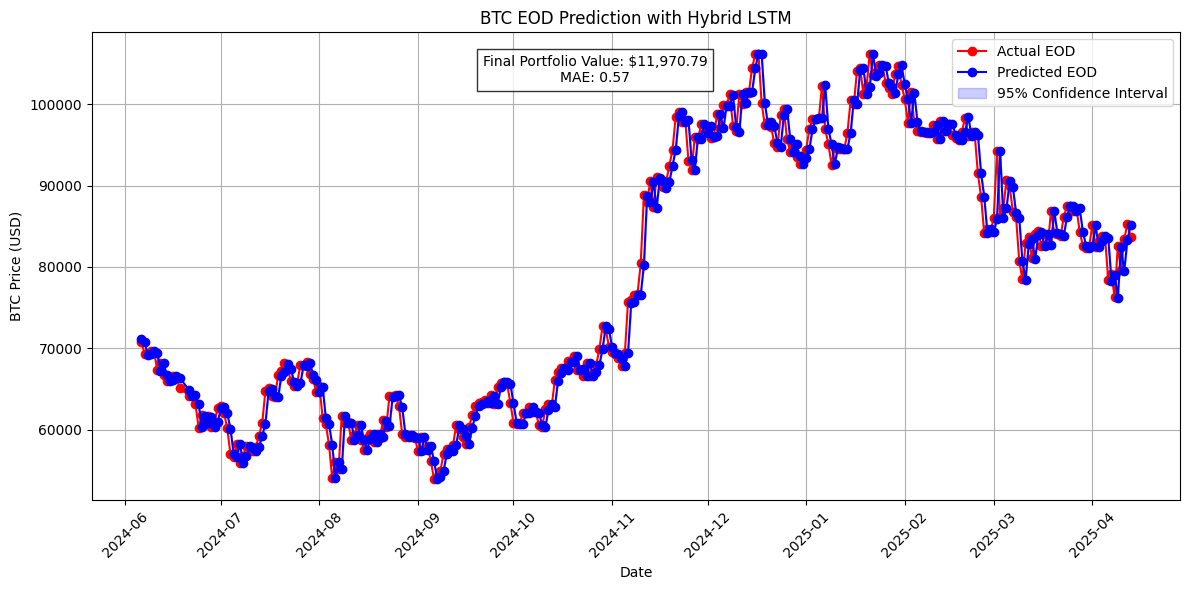

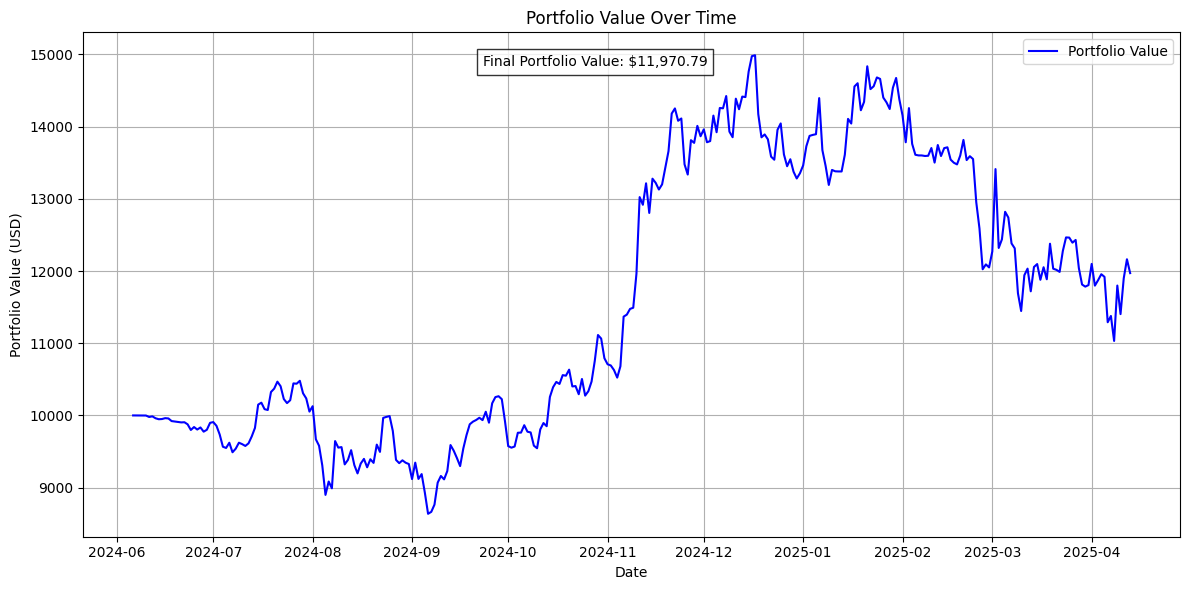


=== TRADE PERFORMANCE SUMMARY ===
Total Trades: 29
Win Rate (%): 65.52
Avg Win: 14266.34
Avg Loss: -4362.29
Best Trade: 26044.55
Worst Trade: -9553.56
Net Profit: 227437.68
[✓] Performance summary saved to: trade_logs/trade_performance_summary.csv


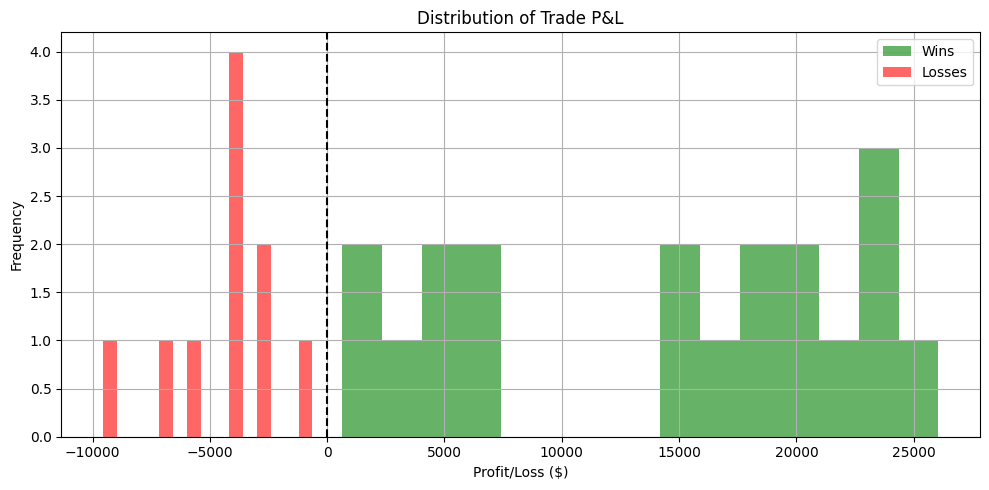

[✓] Histogram saved to: analytics/pnl_histogram.png


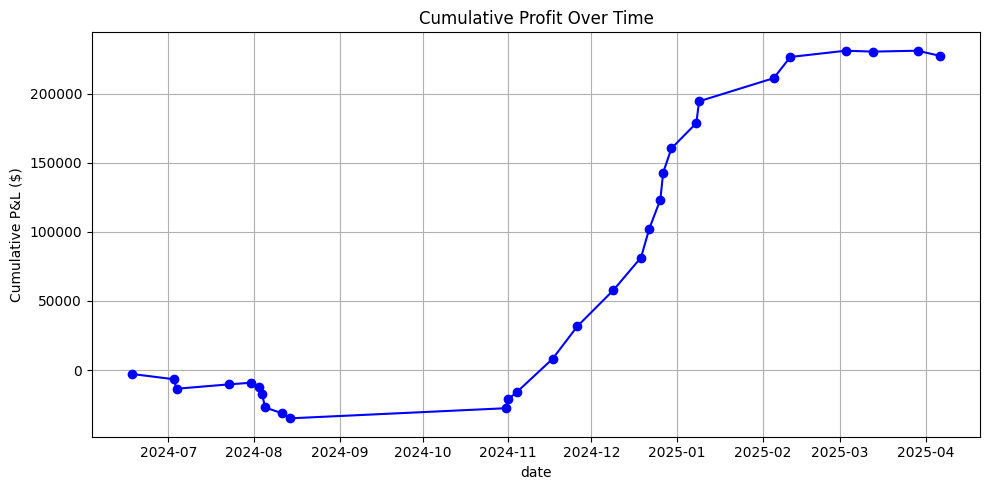

[✓] Cumulative profit chart saved to: analytics/cumulative_profit.png


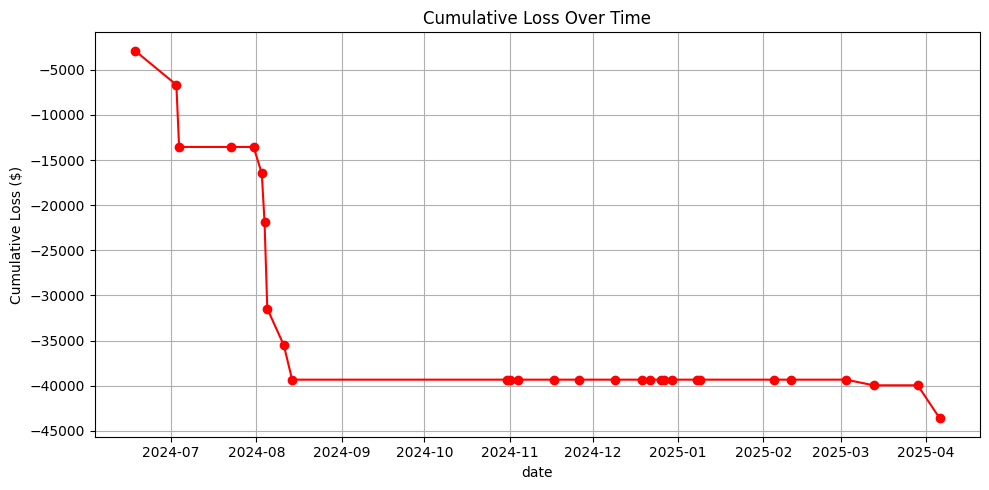

[✓] Cumulative loss chart saved to: analytics/cumulative_loss.png


{'Total Trades': 29,
 'Win Rate (%)': 65.52,
 'Avg Win': 14266.34,
 'Avg Loss': -4362.29,
 'Best Trade': 26044.55,
 'Worst Trade': -9553.56,
 'Net Profit': 227437.68}

In [30]:
import matplotlib.pyplot as plt
from statistics import mean

def analyze_trade_wins(trade_log, csv_path="trade_logs/trade_performance_summary.csv", plot_dir="analytics"):
    os.makedirs(plot_dir, exist_ok=True)

    if not trade_log:
        print("No trades to analyze.")
        return {}

    trades = pd.DataFrame(trade_log)
    trades['date'] = pd.to_datetime(trades['date'])
    trades = trades.sort_values('date')

    # Track open and closed trades
    holding = 0
    entry_price = 0
    pnl_list = []

    for _, row in trades.iterrows():
        if row['decision'] == 'BUY':
            holding += 1
            entry_price += row['actual_eod']
        elif row['decision'] == 'SELL' and holding > 0:
            avg_entry = entry_price / holding
            pnl = row['actual_eod'] - avg_entry
            pnl_list.append({
                'date': row['date'],
                'pnl': pnl
            })
            holding -= 1
            entry_price -= avg_entry

    if not pnl_list:
        print("No closed positions (BUY followed by SELL).")
        return {}

    pnl_df = pd.DataFrame(pnl_list)
    pnl_df['cumulative_pnl'] = pnl_df['pnl'].cumsum()

    wins = pnl_df[pnl_df['pnl'] > 0]['pnl'].tolist()
    losses = pnl_df[pnl_df['pnl'] <= 0]['pnl'].tolist()

    stats = {
        'Total Trades': len(pnl_df),
        'Win Rate (%)': round(len(wins) / len(pnl_df) * 100, 2),
        'Avg Win': round(mean(wins), 2) if wins else 0.0,
        'Avg Loss': round(mean(losses), 2) if losses else 0.0,
        'Best Trade': round(max(wins), 2) if wins else 0.0,
        'Worst Trade': round(min(losses), 2) if losses else 0.0,
        'Net Profit': round(sum(pnl_df['pnl']), 2)
    }

    print("\n=== TRADE PERFORMANCE SUMMARY ===")
    for k, v in stats.items():
        print(f"{k}: {v}")

    pd.DataFrame([stats]).to_csv(csv_path, index=False)
    print(f"[✓] Performance summary saved to: {csv_path}")

    # P&L Histogram
    plt.figure(figsize=(10, 5))
    plt.hist(wins, bins=15, alpha=0.6, label='Wins', color='green')
    plt.hist(losses, bins=15, alpha=0.6, label='Losses', color='red')
    plt.axvline(0, color='black', linestyle='--')
    plt.title("Distribution of Trade P&L")
    plt.xlabel("Profit/Loss ($)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    hist_path = os.path.join(plot_dir, "pnl_histogram.png")
    plt.savefig(hist_path)
    plt.show(block=False)
    plt.pause(3)
    print(f"[✓] Histogram saved to: {hist_path}")
    plt.close()

    # Cumulative P&L Chart
    plt.figure(figsize=(10, 5))
    plt.plot(pnl_df['date'], pnl_df['cumulative_pnl'], marker='o', color='blue')
    plt.title("Cumulative Profit Over Time")
    plt.xlabel("date")
    plt.ylabel("Cumulative P&L ($)")
    plt.grid(True)
    plt.tight_layout()
    cum_path = os.path.join(plot_dir, "cumulative_profit.png")
    plt.savefig(cum_path)
    plt.show(block=False)
    plt.pause(3)
    print(f"[✓] Cumulative profit chart saved to: {cum_path}")
    plt.close()

    # Cumulative Loss Only Chart
    pnl_df['loss_only'] = pnl_df['pnl'].apply(lambda x: x if x < 0 else 0)
    pnl_df['cumulative_loss'] = pnl_df['loss_only'].cumsum()

    plt.figure(figsize=(10, 5))
    plt.plot(pnl_df['date'], pnl_df['cumulative_loss'], marker='o', color='red')
    plt.title("Cumulative Loss Over Time")
    plt.xlabel("date")
    plt.ylabel("Cumulative Loss ($)")
    plt.grid(True)
    plt.tight_layout()
    loss_path = os.path.join(plot_dir, "cumulative_loss.png")
    plt.savefig(loss_path)
    plt.show(block=False)
    plt.pause(3)
    print(f"[✓] Cumulative loss chart saved to: {loss_path}")
    plt.close()

    return stats


print("\nSimulation Complete")
print(f"Final Portfolio Value: ${portfolio_values[-1]:,.2f}")
print(f"Total Trades: {sum(1 for t in trade_log if t['decision'] != 'HOLD')}")

os.makedirs("trade_logs", exist_ok=True)
pd.DataFrame(trade_log).to_csv('trade_logs/trade_log.csv', index=False)
print("Trade log saved to trade_log.csv")

mae = mean_absolute_error(y_true_inv, y_pred_inv)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime([t['date'] for t in trade_log]), [t['actual_eod'] for t in trade_log], label="Actual EOD", color='red', marker='o')
plt.plot(pd.to_datetime([t['date'] for t in trade_log]), [t['predicted_eod'] for t in trade_log], label="Predicted EOD", color='blue', marker='o')
plt.fill_between(
    pd.to_datetime([t['date'] for t in trade_log]),
    [t['predicted_eod'] - t['pred_std'] for t in trade_log],
    [t['predicted_eod'] + t['pred_std'] for t in trade_log],
    color='blue', alpha=0.2, label="95% Confidence Interval"
)
plt.title("BTC EOD Prediction with Hybrid LSTM")
plt.gcf().text(0.5, 0.90, f"Final Portfolio Value: ${portfolio_values[-1]:,.2f}\nMAE: {mae:.2f}",
                fontsize=10, ha='center', va='top', bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))
plt.xlabel("Date")
plt.ylabel("BTC Price (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("plots/eod_prediction.png")
plt.show(block=False)
plt.pause(3)
plt.close('all')

# Portfolio value over time
plot_dates = pd.to_datetime([t['date'] for t in trade_log])
portfolio_vals = [t['portfolio_value'] for t in trade_log]

plt.figure(figsize=(12, 6))
plt.plot(plot_dates, portfolio_vals, label="Portfolio Value", color='blue')
plt.title("Portfolio Value Over Time")
plt.gcf().text(0.5, 0.90, f"Final Portfolio Value: ${portfolio_values[-1]:,.2f}",
                fontsize=10, ha='center', va='top', bbox=dict(facecolor='white', edgecolor='black', alpha=0.8))
plt.xlabel("Date")
plt.ylabel("Portfolio Value (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("plots/portfolio_value_over_time.png")
plt.show(block=False)
plt.pause(3)
plt.close('all')

# Analyze effectiveness
analyze_trade_wins(trade_log)
